---
# KMeans
---

A quick tutorial on K-Means

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

Below is a function for visualizing 3D clusters

In [2]:
np.seterr(divide='ignore')

def plot_3d(x, y=None, title='Clusters'):
    '''
    Takes a 2D array of 3D observations
    and visualizes it with a 3D scatter pot.

    Args:
        x - 2d-darray: shape=(n_sample, n_features + 1 for labels if y is None)
        y - array-like, labels

    Returns:
        pyplot.show() - 3D scatter
    '''
    if y is None:
        y = x[:, -1]
        x = x[:, :-1]
    plt.figure(figsize=(7, 6))
    plt.gca(projection='3d', xlabel='$x_1$', ylabel='$x_2$', zlabel='$x_3$')
    plt.gca().scatter(*x.T, c=y)
    plt.title(title, fontsize=20)
    plt.show()

---
### Euclidean Distance

The k-means algorithm takes an iterative approach and often performs very well in practice. For it to work, it requires a distance metric in order to group the dataset into clusters. The standard metric is (the squared) Euclidean distance, which is given by the equation:

\begin{align*}
d(\mathbf{x},\mathbf{y}) =  \sum_{i=1}^{n}||x_i - y_i||_2^2
\end{align*}

In [3]:
def squared_euclidean_distance(x1, x2):
    return ((x1 - x2) ** 2).sum(axis=len(x1.shape) - 1)

Below we will define a toy dataset with 3 clusters

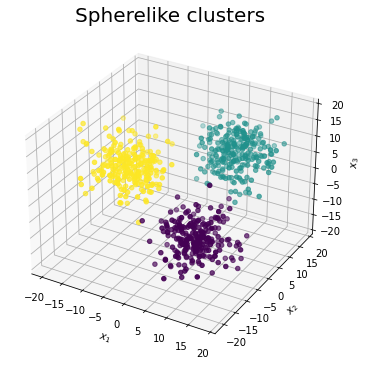

In [4]:
from sklearn.datasets import make_blobs
n = 250
centers = np.array([[1, -1, -1],
                    [1, 1, 1],
                    [-1, -1, 1]])

centers *= 8
blob_x, blob_y = make_blobs(3 * n, n_features=3, centers=centers, cluster_std=4, random_state=42)
plot_3d(blob_x, blob_y, 'Spherelike clusters')

Below we will define the K-means algorithm using euclidean distance.

K-means is essentially and opimization algorithm that aims to minimize the distance between each data point and cluster centroids. The objective function can be thought of as:  


\begin{align*}
D = \sum_{j=1}^{k}\sum_{i=1}^{n}d(x_i, c_j)
\end{align*}

where k is the number of clusters (partition order)

In [5]:
def euclidean_k_means(x, k, n_iter=300):
    '''
    Partitions data into k clusters
    
    Args:
        x      - array-like, shape=(n_sample, n_feature), samples
        k      - int, partition order, number of clusters
        n_iter - int, maximum number of iterations of algorithm

    Returns:
        p      - array-like, shape=(n_sample,), partition
    '''
    k_range     = range(k)
    n_sample    = len(x)
    centroids   = x[np.random.randint(n_sample, size=k)]
    p_partition = None

    for i in range(n_iter):
        distances   = [squared_euclidean_distance(x, centroids[j]) for j in k_range]
        c_partition = np.argmin(distances, axis=0)

        for j in k_range:
            cluster = x[c_partition == j]
            if len(cluster):
                centroids[j] = cluster.mean(axis=0)
            else: # reinitialize empty clusters
                r = np.random.randint(n_sample, size=1)
                c_partition[r] = j
                centroids[j]   = x[r]

        if np.array_equal(p_partition, c_partition):
            break

        p_partition = c_partition
    
    return p_partition

We will use normalized mutual information to score performance  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html#sklearn.metrics.mutual_info_score.

In [6]:
from sklearn.metrics import normalized_mutual_info_score

It can be seen below that euclidean K-Means performs well in this situation but there are a couple of things to consider:

Euclidean K-Means assumes that the centroids are the centers of spherical clusters

The clusters in our toy dataset are spherelike

There is no overlap between clusters

We knew the value of k a priori

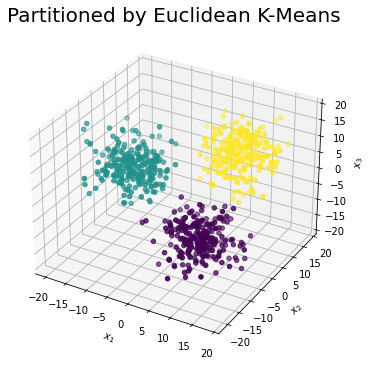

Normalized_mutual_info 0.9779428542667044


In [7]:
p = euclidean_k_means(blob_x, 3)
plot_3d(blob_x, p, 'Partitioned by Euclidean K-Means')
print('Normalized_mutual_info', normalized_mutual_info_score(blob_y, p))

---

#### What if we do not know k?

This is a problem to which there is no great solution.  
There are a number of different approaches that one may use but one of the most recognized and often successful is the Davies Bouldin Index (DBI).

In [8]:
def davies_bouldin_index(x, p, k):
    '''
    Calculates the Davies Bouldin index of a cluster model
    
    Args:
        x - array-like, shape=(n_sample, n_feature), samples
        p - array-like, shape=(n_sample,), partition
        k - int, partition order, number of clusters

    Returns:
        Davies Bouldin index - float
    '''
    db_idx = 0.

    for i in range(k):

        max_dij = 0.
        cluster_i  = x[p == i]
        centroid_i = cluster_i.mean(axis=0)
        avg_intra_distance_i = squared_euclidean_distance(cluster_i, centroid_i).mean()

        for j in range(i + 1, k):
            cluster_j  = x[p == j]
            centroid_j = cluster_j.mean(axis=0)
            avg_intra_distance_j = squared_euclidean_distance(cluster_j, centroid_j).mean()
            
            inter_distance = squared_euclidean_distance(centroid_i, centroid_j) 
            dij = (avg_intra_distance_i + avg_intra_distance_j) / inter_distance

            if dij > max_dij:
                max_dij = dij

        db_idx += max_dij

    return db_idx / k

The Davies Boulding index considers, not only intra cluster distances, but also `inter` cluster distances.  
A value of k achieving the minimum DBI could be the correct value of k for that dataset.  
It can be seen below that calculating DBI for k values 1 < k < 7, that 3 clusters is most strongly evidenced which was
the number we created earlier.

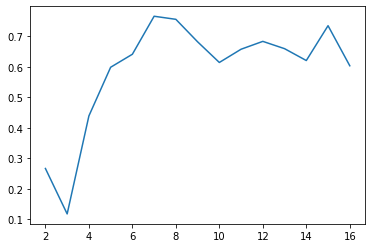

best value for dbi: 3


In [9]:
dbi = []

for k in range(2, 17):
    p = euclidean_k_means(blob_x, k)
    dbi.append(davies_bouldin_index(blob_x, p, k))

plt.figure()
plt.plot(range(2, 17), dbi)
plt.show()
print('best value for dbi:', dbi.index(min(dbi)) + 2)

---
## Mahalanobis Distance

Euclidean distance is only useful in some very specific cases that in practice do not occur much. However, we can use the mahalanobis distance, which is more successful because it takes into account the covariance of a cluster and therefore, the non-spherical shape.

Below we will generate some ellipsoidal clusters.

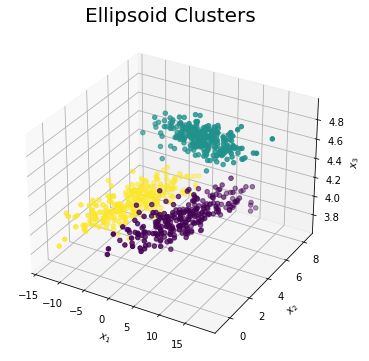

X shape: (750, 3)
targets shape: (750,)


In [10]:
# Generate synthetic 3D data set of ellipsoid clusters

np.random.seed(0)

mu1 = np.array([4, 4, 4])

sigma1 = np.array([[8, 4, 0],
                   [4, 3, 0],
                   [0, 0, 0.01]])

mu2 = np.array([5, 5.2, 4.7])

sigma2 = np.array([[20, -.1, 0],
                   [-.1, 0.05, 0],
                   [0, 0, 0.01]])

mu3 = np.array([-6, 4, 4]) 

sigma3 = np.array([[8, 4, 0],
                   [4, 3, 0],
                   [0, 0, 0.01]])

a = np.random.multivariate_normal(mu1, sigma1, n)
b = np.random.multivariate_normal(mu2, sigma2, n)
c = np.random.multivariate_normal(mu3, sigma3, n)

class1 = np.hstack((a, np.zeros((a.shape[0], 1)))) # Adding classes
class2 = np.hstack((b, np.ones((b.shape[0], 1))))
class3 = np.hstack((c, np.full((c.shape[0], 1), 2)))

# Format data into 2D array with columns as variables and rows as observations
elli_x = np.vstack((class1, class2, class3))

plot_3d(elli_x, title='Ellipsoid Clusters') # Visualize data

np.random.shuffle(elli_x)

elli_x, elli_y = elli_x[:, :3], elli_x[:, 3]

print('X shape:', elli_x.shape)
print('targets shape:', elli_y.shape)

Lets try and cluster the data with euclidean K-Means with k=3

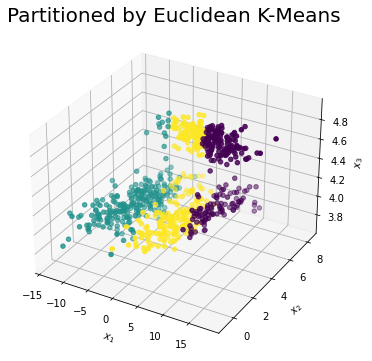

In [11]:
p = euclidean_k_means(elli_x, 3)

plot_3d(elli_x, p, 'Partitioned by Euclidean K-Means')

It can be seen even with running the algorithm multiple times that euclidean distance fails and is not a good metric in this situation.  
The algorithm gets stuck easlily in a local optima with low suitability.

Mahalanobis distance uses the covariance matrix of the data inside each cluster. The covariance matrix is as follows:

\begin{align*}
S = \frac{1}{N-1}X^TX
\end{align*}

Where $X\in \mathbb{R}^{N \times d}$ is the data matrix of cluster $C$.

Using the covariance matrix, you can calculate Mahalanobis distance using the below equation:

\begin{align*}
d_M(x,C) = \sqrt{(x-\mu)^TS^{-1}(x-\mu)}
\end{align*}

In fact, if a cluster is perfectly spherical, it will have a covariance matrix that is equal to the identity matrix of the same size. In this case the mahalanobis distance equation calculates euclidean distance.

Below I've coded a vectorized form of mahalanobis distance designed to work on 2D arrays. Note that I have also coded the squared mahalanobis distance because I can't see why it is normal to use squared euclidean distance but not mahalanobis. If anybody knows, feel free to contact me. This approach also avoids the divide by zero errors encountered with square rooting.

In [12]:
def mahalanobis_distance(x, centroid, cov):
    d = x - centroid
    d = d @ np.linalg.inv(cov) @ d.T
    return np.diag(d) if len(d.shape) > 1 and d.shape[1] > 1 else d

In [13]:
def mahalanobis_k_means(x, k, n_iter=300):
    '''
    Partitions data into k clusters
    
    Args:
        x      - array-like, shape=(n_sample, n_feature), samples
        k      - int, partition order, number of clusters
        n_iter - int, maximum number of iterations of algorithm

    Returns:
        p      - array-like, shape=(n_sample,), partition
    '''

    k_range             = range(k)
    n_sample, n_feature = x.shape
    centroids           = [None] * k
    cov_mats            = [None] * k
    p_partition         = euclidean_k_means(x, k, n_iter)

    for i in range(n_iter):
        for j in k_range:

            cluster = x[p_partition == j]
            n_local = len(cluster)
            if n_local > 1: # more than 1 for covariance matrix
                centroids[j] = cluster.mean(axis=0)
                cov_mats[j]  = np.cov(cluster.T, ddof=1)
            else:
                cov_mats[j]  = np.eye(n_feature)
                if n_local:
                    centroids[j] = cluster
                else:
                    r = np.random.randint(n_sample, size=1)
                    centroids[j]   = x[r]
                    c_partition[r] = j

        distances   = [mahalanobis_distance(x, centroids[j], cov_mats[j]) for j in k_range]
        c_partition = np.argmin(distances, axis=0)

        if np.array_equal(c_partition, p_partition):
            break

        p_partition = c_partition
    
    return p_partition, centroids, cov_mats

It can be seen above that we start by running euclidean K-Means first in order to get initial centroid positions and then use K-Means with the mahalanobis distance to get out of local optima.  
Although, there are many ways to initialize the centroids, this was easiest to implement and works incredibly well. 

Furthermore, it should be noted that we have updated the K-Means algorithm to output the centroids and covariance matrices so we do not have to
recompute these for calculating DBI.

It can be seen below that the mahalanobis distance does a much better job than euclidean.

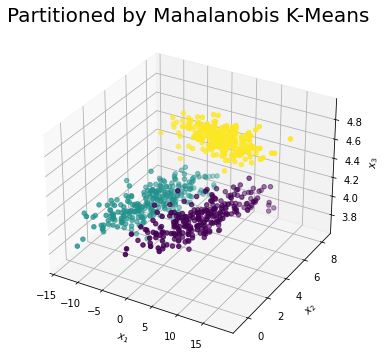

Normalized_mutual_info 1.0


In [14]:
p = mahalanobis_k_means(elli_x, 3)[0]
plot_3d(elli_x, p, title='Partitioned by Mahalanobis K-Means')
print('Normalized_mutual_info', normalized_mutual_info_score(elli_y, p))

#### Can we calculate DBI with mahalanobis distance?

Indeed this is possible.  
The main consideration is when calculating inter cluster distances between two clusters because we have to consider two covariance matrices.  
The solution is to add the covariances matrices of the two clusters together in order to get a common covariance matrix.

In [15]:
def mahalanobis_davies_bouldin_index(x, p, centroids, cov_mats, k):
    '''
    Calculates the Davies Bouldin index of a cluster model
    
    Args:
        x         - ndarray, shape=(n_sample, n_feature), samples
        p         - ndarray, shape=(n_sample,), partition
        centroids - list, of length k containing ndarrays shape=(1, n_feature)
        cov_mats  - list, of length k containing ndarrays shape=(n_feature, n_feature)
        k         - int, partition order, number of clusters

    Returns:
        Davies Bouldin index - float
    '''
    db_idx = 0.

    for i in range(k):
        max_dij   = 0.
        cluster_i = x[p == i]
        avg_intra_distance_i = mahalanobis_distance(cluster_i, centroids[i], cov_mats[i]).mean()

        for j in range(i + 1, k):
            cluster_j = x[p == j]
            avg_intra_distance_j = mahalanobis_distance(cluster_j, centroids[j], cov_mats[j]).mean()

            inter_distance = mahalanobis_distance(centroids[i], centroids[j], cov_mats[i] + cov_mats[j])
            dij = (avg_intra_distance_i + avg_intra_distance_j) / inter_distance
            if dij > max_dij:
                max_dij = dij

        db_idx += max_dij

    return db_idx / k

We can see this works well in this situation.

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.49it/s]


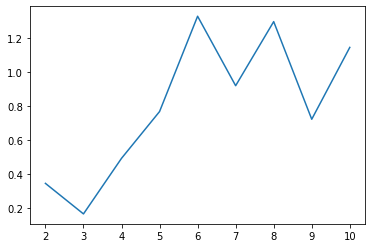

best value for dbi: 3


In [16]:
dbi = []

for k in tqdm(range(2, 11)):
    p_info = mahalanobis_k_means(elli_x, k)
    dbi.append(mahalanobis_davies_bouldin_index(elli_x, *p_info, k))

plt.figure()
plt.plot(range(2, 11), dbi)
plt.show()
print('best value for dbi:', dbi.index(min(dbi)) + 2)